# Data Deep Dive.

In [1]:
!cp /whhdata/dbconnection.json .

In [2]:
%matplotlib inline
import sys
sys.path.insert(0, "..")
import dbutils
from cgmcore import utils
import matplotlib.pyplot as plt
import pandas as pd
import glob2
import os
import config
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display, clear_output
import itertools
from tqdm import tqdm

In [3]:
all_levels = ["scan", "artifact"]
all_datasets = ["all", "training", "nottraining"]
limits = [0.2, 0.4, 0.6, 1.2, "all"]

# Select model.

In [4]:
# Getting the models.
db_connector = dbutils.connect_to_main_database()
select_sql_statement = "SELECT DISTINCT(type) FROM artifact_quality;"
types = db_connector.execute(select_sql_statement, fetch_all=True)
models_in_database = [t[0] for t in types if len(t[0]) > 20]

selected_model = None

@interact(models=models_in_database)
def select_model(models):
    global selected_model
    selected_model = models
    print("Selected model '{}'.".format(selected_model))

interactive(children=(Dropdown(description='models', options=('20190806-1551_220-55height', '20190718-2123_255…

# Error on scan and artifact level.

In [5]:
def error_cache_entry_name(level, dataset):
    return "-".join([level, dataset])

# Create a cache for the visual results.
print("Filling cache. This might take a while...")
error_cache_entries = {}
for level, dataset in itertools.product(all_levels, all_datasets):
    
    print("Caching {} {}...".format(level, dataset))

    #Cache key.
    cache_key = error_cache_entry_name(level, dataset)
    
    # SQL statement for scan level.
    if level == "scan":
        select_sql_statement = ""
        select_sql_statement += "SELECT AVG(aq.value) FROM artifact_quality aq"
        select_sql_statement += " INNER JOIN artifact a ON a.id = aq.artifact_id"
        select_sql_statement += " WHERE aq.key='mae'"
        select_sql_statement += " AND aq.type='{}'".format(selected_model)
        if dataset != "all":
            select_sql_statement += " AND misc = '{}'".format(dataset)
        select_sql_statement += " GROUP BY a.qr_code, a.create_date"
        select_sql_statement += ";"
    
    # SQL statement for artifact level.
    elif level == "artifact":
        select_sql_statement = ""
        select_sql_statement += "SELECT value FROM artifact_quality" 
        select_sql_statement += " WHERE type='{}' AND key='mae'".format(selected_model)
        if dataset != "all":
            select_sql_statement += " AND misc = '{}'".format(dataset)
        select_sql_statement += ";"
    
    # Retrieve results from DB.
    results = db_connector.execute(select_sql_statement, fetch_all=True)
    results = [x[0] for x in results]
    
    # Store in cache.
    error_cache_entries[cache_key] = results
print("Cache filled.")
    
    
# Create interactive widget.
@interact(levels=all_levels, datasets=all_datasets, bins=[100, 200, 400, 800])
def visualize(levels, datasets, bins):
    
    # Get results from cache.
    cache_key = error_cache_entry_name(levels, datasets)
    results = error_cache_entries[cache_key]
    
    # Render.
    plt.figure(figsize=(15, 6))
    plt.hist(results, bins=bins)
    plt.title("Error for {} {}s for {} and model {}.".format(len(results), levels, datasets, selected_model))
    plt.show()
    plt.close()

Filling cache. This might take a while...
Caching scan all...
Caching scan training...
Caching scan nottraining...
Caching artifact all...
Caching artifact training...
Caching artifact nottraining...
Cache filled.


interactive(children=(Dropdown(description='levels', options=('scan', 'artifact'), value='scan'), Dropdown(des…

## Gold Standard Results on scan and artifact level.

In [6]:
def goldstandard_cache_entry_name(level, dataset):
    return "-".join([level, dataset])

# Create a cache for the visual results.
print("Filling cache. This might take a while...")
goldstandard_cache_entries = {}
for level, dataset in itertools.product(all_levels, all_datasets):
    
    print("Caching {} {}...".format(level, dataset))

    # Getting scan count from database.
    if level == "scan":
        select_sql_statement = ""
        select_sql_statement += "SELECT COUNT(DISTINCT(a.qr_code, a.create_date))"
        select_sql_statement += " FROM artifact a"
        select_sql_statement += " INNER JOIN artifact_quality aq ON a.id = aq.artifact_id"
        select_sql_statement += " WHERE aq.key='mae'"
        select_sql_statement += " AND aq.type='{}'".format(selected_model)
        if dataset != "all":
            select_sql_statement += " AND aq.misc = '{}'".format(dataset)
        select_sql_statement += ";"
        all_count = db_connector.execute(select_sql_statement, fetch_one=True)[0]

    # Getting artifact count from database.
    elif level == "artifact":
        select_sql_statement = ""
        select_sql_statement += "SELECT COUNT(*) FROM artifact_quality aq WHERE aq.type='{}' AND aq.key='mae'".format(selected_model)
        if dataset != "all":
            select_sql_statement += " AND aq.misc = '{}'".format(dataset)
        select_sql_statement += ";"
        all_count = db_connector.execute(select_sql_statement, fetch_one=True)[0]

    #Cache key.
    cache_key = goldstandard_cache_entry_name(level, dataset)
    
    # Get the rows.
    rows = []
    for limit in limits:
        
        # SQL statement for scan level.
        if level == "scan":
            select_sql_statement = "SELECT COUNT(v) FROM ("
            select_sql_statement += " SELECT AVG(aq.value) as v FROM artifact_quality aq"
            select_sql_statement += " INNER JOIN artifact a ON a.id = aq.artifact_id"
            select_sql_statement += " WHERE aq.key='mae'"
            select_sql_statement += " AND aq.type='{}'".format(selected_model)
            if dataset != "all":
                select_sql_statement += " AND misc = '{}'".format(dataset)
            
            select_sql_statement += " GROUP BY a.qr_code, a.create_date"
            select_sql_statement += ") AS subquery"
            if limit != "all":
                select_sql_statement += " WHERE v <= {}".format(limit)
            select_sql_statement += ";"
        
        # SQL statement for artifact level.
        elif level == "artifact":
            select_sql_statement = ""
            select_sql_statement += "SELECT COUNT(aq) FROM artifact_quality aq" 
            select_sql_statement += " WHERE type='{}' AND key='mae'".format(selected_model)
            if dataset != "all":
                select_sql_statement += " AND misc = '{}'".format(dataset)
            if limit != "all":
                select_sql_statement += " AND value <={}".format(limit)
            select_sql_statement += ";"

        # Retrieve results from database.
        below_limit_count = db_connector.execute(select_sql_statement, fetch_one=True)[0]
        
        # Compute per cent.
        percent = 100 * below_limit_count / all_count

        # Come up with a nice description.
        description = "All"
        if limit != "all":
            description = "AE <= {}mm".format(int(10 * limit))

        rows.append((description, below_limit_count, round(percent, 2)))
    
    # Store in cache.
    goldstandard_cache_entries[cache_key] = rows
print("Cache filled.")


# Create interactive widget.
@interact(levels=["scan", "artifact"], datasets=["all", "training", "nottraining"])
def visualize(levels, datasets):

    # Get data from cache.
    cache_key = goldstandard_cache_entry_name(levels, datasets)
    rows = goldstandard_cache_entries[cache_key]

    # Create and render dataframe.
    headers = ("Description", "Number", "%")
    df = pd.DataFrame(rows, columns=headers)
    display(df)

Filling cache. This might take a while...
Caching scan all...
Caching scan training...
Caching scan nottraining...
Caching artifact all...
Caching artifact training...
Caching artifact nottraining...
Cache filled.


interactive(children=(Dropdown(description='levels', options=('scan', 'artifact'), value='scan'), Dropdown(des…

# Rendering measures selected by high/low error.

Dropdown(description='Order', layout=Layout(width='initial'), options=('ASC', 'DESC'), value='ASC')

Dropdown(description='Measure', layout=Layout(width='initial'), options=('Error: 0.36090087890625 Measure: 751…

Rendering...


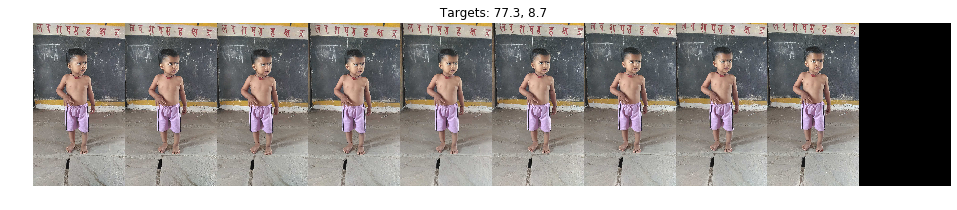

In [7]:
def get_entries(order):

    select_sql_statement = """
        SELECT * FROM (
            SELECT AVG(aq.value) AS average, m.id AS measure_id, COUNT(aq) AS count
            FROM measure m
            INNER JOIN artifact a ON a.measure_id = m.id
            INNER JOIN artifact_quality aq ON aq.artifact_id = a.id
            WHERE aq.type='{}'
            AND aq.key='mae'
            GROUP BY m.id
        ) AS all_measures
        ORDER BY average {}
        LIMIT 50
        ;
        """.format(selected_model, order)

    results = db_connector.execute(select_sql_statement, fetch_all=True)
    return results

# Graphical user interface.
order_widget = None
error_widget = None
selected_measure_id = None

def clear_and_render_widgets():
    clear_output()
    if order_widget != None:
        display(order_widget)
    if error_widget != None:
        display(error_widget)
    if selected_measure_id != None:
        print("Rendering...")
        artifacts, targets = get_artifacts_for_measure(selected_measure_id)
        utils.render_artifacts_as_gallery(artifacts, targets=targets)

def create_order_selector():
    global order_widget
    options = ["ASC", "DESC"]
    order_widget = widgets.Dropdown(
        layout={'width': 'initial'},
        options = options,
        value=options[0],
        description="Order",
    )

    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            create_error_selector(change['new'])
            clear_and_render_widgets()
    order_widget.observe(on_change)
    
    create_error_selector(options[0])

    
# Create interactive widget.
#@interact(order=["ASC", "DESC"])
def create_error_selector(order):
    
    results = get_entries(order)
    
    global selected_measure_id
    selected_measure_id = results[0][1]
    
    global error_widget
    options = ["Error: {} Measure: {}".format(error, measure_id) for error, measure_id, _ in results]
    error_widget = widgets.Dropdown(
        layout={'width': 'initial'},
        options = options,
        value=options[0],
        description="Measure",
    )

    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            index = options.index(change['new'])
            global selected_measure_id
            selected_measure_id = results[index][1]
            clear_and_render_widgets()
    error_widget.observe(on_change)
    clear_and_render_widgets()
        
def get_artifacts_for_measure(measure_id):
    sql_statement = ""
    sql_statement += "SELECT path, height, weight FROM artifact AS a "
    sql_statement += " INNER JOIN measure m ON m.id = a.measure_id"
    sql_statement += " WHERE a.measure_id='{}'".format(measure_id)
    sql_statement += " AND a.type='rgb'"
    sql_statement += ";"
    paths = db_connector.execute(sql_statement, fetch_all=True)
    
    sql_statement = ""
    sql_statement += "SELECT height, weight FROM measure m "
    sql_statement += " WHERE m.id='{}'".format(measure_id)
    sql_statement += ";"
    targets = db_connector.execute(sql_statement, fetch_one=True)
    
    return paths, targets
        
create_order_selector()

## Available Data in Storage (rgb scans, pcd scans)  => rgb = > 16331 &  pcd => 5049

# TODO Tristan: This can be optimized a lot with glob, I guess.

## Getting the number of GB files 
sum_jpg = 0
sum_pcd = 0

search_path = config.artifacts_path + "/"

block = [".DS_Store", "DEMO_TEST_0001", "._data"]
for file in tqdm((os.listdir(search_path))):
    if(file not in block):
        for file1 in os.listdir(search_path + file):
            if(file1 == "measurements"):
                for file2 in os.listdir(search_path + file + "/" + file1 + "/"):
                    for file3 in os.listdir(search_path + file + "/" + file1 + "/" + file2 + "/"):
                        if(file3=="pc"):
                            sum_pcd  = sum_pcd + len(os.listdir(search_path+file+"/measurements/"+file2+"/"+file3))
                        if(file3=="rgb"):
                            sum_jpg = sum_jpg + len(os.listdir(search_path+file+"/measurements/"+file2+"/"+file3))
print("Number of rgb scans in Storage :  " + str(sum_jpg)) 
print("Number of pc scans in Storage :  " + str(sum_pcd)) 